<a href="https://colab.research.google.com/github/nbadino/ItaOil/blob/main/paralleltrends22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install tqdm
!pip install requests
import requests
import tarfile
import os
import concurrent.futures
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import shutil
#shutil.rmtree("/content/datasets")



In [9]:

def download_and_extract(year, quarter, base_url, folder_name, pbar):
    # Construct the full URL
    file_url = f"{base_url}{year}/{year}_{quarter}_tr.tar.gz"

    # Ensure the directory exists
    folder_path = os.path.join("datasets", folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Download the file
    response = requests.get(file_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte
    file_path = os.path.join(folder_path, f"{year}_{quarter}_tr.tar.gz")

    with open(file_path, 'wb') as file:
        for data in tqdm(response.iter_content(block_size), desc=f"Downloading {year}_{quarter} to {folder_name}", total=total_size//block_size, unit='KiB', unit_scale=True):
            file.write(data)

    # Extract the tar.gz file
    with tarfile.open(file_path, 'r:gz') as tar:
        for member in tqdm(tar.getmembers(), desc=f"Extracting {year}_{quarter} to {folder_name}"):
            tar.extract(member, path=folder_path)

    # Remove the tar.gz file after extraction
    os.remove(file_path)
    pbar.update(1)

# Base URLs and corresponding folders
url_folder_mapping = {
    "https://opendatacarburanti.mise.gov.it/categorized/anagrafica_impianti_attivi/": "anagrafica",
    "https://opendatacarburanti.mise.gov.it/categorized/prezzo_alle_8/": "prezzi"
}

tasks = [(year, quarter, base_url, folder_name) for base_url, folder_name in url_folder_mapping.items() for year in range(2022, 2024) for quarter in range(1, 5) if not (year == 2023 and quarter > 2)]

# Use a ThreadPoolExecutor to download multiple files concurrently
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor, tqdm(total=len(tasks), desc="Overall Progress", position=0) as pbar:
    futures = [executor.submit(download_and_extract, year, quarter, base_url, folder_name, pbar) for year, quarter, base_url, folder_name in tasks]

    for future in concurrent.futures.as_completed(futures):
        future.result()

print("Download and extraction complete!")

Overall Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Extracting 2022_2 to anagrafica:   0%|          | 0/91 [00:00<?, ?it/s]

Extracting 2022_1 to anagrafica:   0%|          | 0/88 [00:00<?, ?it/s]

Extracting 2022_4 to anagrafica:   0%|          | 0/92 [00:00<?, ?it/s]

Extracting 2022_3 to anagrafica:   0%|          | 0/93 [00:00<?, ?it/s]

Extracting 2022_2 to prezzi:   0%|          | 0/91 [00:00<?, ?it/s]

Extracting 2022_1 to prezzi:   0%|          | 0/88 [00:00<?, ?it/s]

Extracting 2023_1 to anagrafica:   0%|          | 0/90 [00:00<?, ?it/s]

Extracting 2023_2 to anagrafica:   0%|          | 0/91 [00:00<?, ?it/s]

Extracting 2022_4 to prezzi:   0%|          | 0/95 [00:00<?, ?it/s]

Extracting 2022_3 to prezzi:   0%|          | 0/93 [00:00<?, ?it/s]

Extracting 2023_1 to prezzi:   0%|          | 0/90 [00:00<?, ?it/s]

Extracting 2023_2 to prezzi:   0%|          | 0/91 [00:00<?, ?it/s]

Download and extraction complete!


In [11]:
import requests
import zipfile
import os
import concurrent.futures
from tqdm.notebook import tqdm

def download_and_extract_french(year, url_suffix):
    url = f"https://donnees.roulez-eco.fr/opendata/annee/{url_suffix}"

    # Ensure the directory exists
    folder_path = "datasets/french"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Download the file
    response = requests.get(url, stream=True)

    # Read content into a variable
    content = b"".join(response.iter_content(chunk_size=1024))

    # Write to debug file
    with open(f"{year}_response.txt", 'wb') as debug_file:
        debug_file.write(content)

    total_size = len(content)
    file_path = os.path.join(folder_path, f"{year}.zip")

    # Write to ZIP file
    with open(file_path, 'wb') as file:
        file.write(content)

    # Extract the .zip file
    try:
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            for member in tqdm(zip_ref.infolist(), desc=f"Extracting French data for {year}"):
                zip_ref.extract(member, path=folder_path)
    except zipfile.BadZipFile:
        print(f"Warning: {file_path} is not a valid ZIP file and will be skipped.")

    # Remove the .zip file after extraction
    os.remove(file_path)
    pbar_french.update(1)

# Years and their corresponding URL suffixes
data_mapping = {
    "2022": "2022",
    "2023": ""
}

# Use a ThreadPoolExecutor to download multiple files concurrently
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor, tqdm(total=len(data_mapping), desc="French Data Progress", position=0) as pbar_french:
    futures = [executor.submit(download_and_extract_french, year, url_suffix) for year, url_suffix in data_mapping.items()]

    for future in concurrent.futures.as_completed(futures):
        future.result()

print("Download and extraction of French data complete!")


French Data Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting French data for 2023:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting French data for 2022:   0%|          | 0/1 [00:00<?, ?it/s]

Download and extraction of French data complete!


In [12]:
import os
import pandas as pd

# Paths to the folders
anagrafica_folder = "/content/datasets/anagrafica"
prezzo_folder = "/content/datasets/prezzi"

# Ensure paths are valid
if not os.path.exists(anagrafica_folder) or not os.path.exists(prezzo_folder):
    raise ValueError("One or both paths do not exist. Please check the paths provided.")

# Mapping of Italian provinces (abbreviated) to regions
province_abbrev_to_region = {
    'AG': 'Sicilia', 'AL': 'Piemonte', 'AN': 'Marche', 'AO': 'Valle d\'Aosta',
    'AR': 'Toscana', 'AP': 'Marche', 'AT': 'Piemonte', 'AV': 'Campania',
    'BA': 'Puglia', 'BT': 'Puglia', 'BL': 'Veneto', 'BN': 'Campania',
    'BG': 'Lombardia', 'BI': 'Piemonte', 'BO': 'Emilia-Romagna', 'BZ': 'Trentino-Alto Adige',
    'BS': 'Lombardia', 'BR': 'Puglia', 'CA': 'Sardegna', 'CL': 'Sicilia',
    'CB': 'Molise', 'CE': 'Campania', 'CT': 'Sicilia', 'CZ': 'Calabria',
    'CH': 'Abruzzo', 'CO': 'Lombardia', 'CS': 'Calabria', 'CR': 'Lombardia',
    'KR': 'Calabria', 'CN': 'Piemonte', 'EN': 'Sicilia', 'FM': 'Marche',
    'FE': 'Emilia-Romagna', 'FI': 'Toscana', 'FG': 'Puglia', 'FC': 'Emilia-Romagna',
    'FR': 'Lazio', 'GE': 'Liguria', 'GO': 'Friuli-Venezia Giulia', 'GR': 'Toscana',
    'IM': 'Liguria', 'IS': 'Molise', 'SP': 'Liguria', 'AQ': 'Abruzzo',
    'LT': 'Lazio', 'LE': 'Puglia', 'LC': 'Lombardia', 'LI': 'Toscana',
    'LO': 'Lombardia', 'LU': 'Toscana', 'MC': 'Marche', 'MN': 'Lombardia',
    'MS': 'Toscana', 'MT': 'Basilicata', 'ME': 'Sicilia', 'MI': 'Lombardia',
    'MO': 'Emilia-Romagna', 'MB': 'Lombardia', 'NA': 'Campania',
    'NO': 'Piemonte', 'NU': 'Sardegna', 'OR': 'Sardegna', 'PD': 'Veneto',
    'PA': 'Sicilia', 'PR': 'Emilia-Romagna', 'PV': 'Lombardia', 'PG': 'Umbria',
    'PU': 'Marche', 'PE': 'Abruzzo', 'PC': 'Emilia-Romagna', 'PI': 'Toscana',
    'PT': 'Toscana', 'PN': 'Friuli-Venezia Giulia', 'PZ': 'Basilicata',
    'PO': 'Toscana', 'RG': 'Sicilia', 'RA': 'Emilia-Romagna', 'RC': 'Calabria',
    'RE': 'Emilia-Romagna', 'RI': 'Lazio', 'RN': 'Emilia-Romagna',
    'RM': 'Lazio', 'RO': 'Veneto', 'SA': 'Campania', 'SS': 'Sardegna',
    'SV': 'Liguria', 'SI': 'Toscana', 'SR': 'Sicilia', 'SO': 'Lombardia',
    'SU': 'Sardegna', 'TA': 'Puglia', 'TE': 'Abruzzo', 'TR': 'Umbria',
    'TO': 'Piemonte', 'TP': 'Sicilia', 'TN': 'Trentino-Alto Adige', 'TV': 'Veneto',
    'TS': 'Friuli-Venezia Giulia', 'UD': 'Friuli-Venezia Giulia', 'VA': 'Lombardia',
    'VE': 'Veneto', 'VB': 'Piemonte', 'VC': 'Piemonte', 'VR': 'Veneto',
    'VV': 'Calabria', 'VI': 'Veneto', 'VT': 'Lazio'
}

# Initialize an empty DataFrame to store the final results
final_df = pd.DataFrame()

# Iterate over all files in the folders, skipping directories
for anagrafica_file, prezzo_file in zip(sorted(os.listdir(anagrafica_folder)), sorted(os.listdir(prezzo_folder))):

    anagrafica_path = os.path.join(anagrafica_folder, anagrafica_file)
    prezzo_path = os.path.join(prezzo_folder, prezzo_file)

    # Check if paths point to files and not directories
    if os.path.isfile(anagrafica_path) and os.path.isfile(prezzo_path):

        # Read the datasets
        anagrafica_df = pd.read_csv(anagrafica_path, sep=';', skiprows=2, error_bad_lines=False)
        prezzo_df = pd.read_csv(prezzo_path, sep=';', skiprows=2)

        # Rename columns
        anagrafica_df.columns = ['idImpianto', 'Gestore', 'Bandiera', 'Tipo Impianto', 'Nome Impianto', 'Indirizzo', 'Comune', 'Provincia', 'Latitudine', 'Longitudine']
        prezzo_df.columns = ['idImpianto', 'descCarburante', 'prezzo', 'isSelf', 'dtComu']

        # Merge datasets
        merged_df = pd.merge(prezzo_df, anagrafica_df, on='idImpianto', how='inner')

        # Use date from the first row for the entire dataset
        fixed_date = merged_df['dtComu'].iloc[0]
        merged_df['date'] = fixed_date

        # Map provinces to regions
        merged_df['Regione'] = merged_df['Provincia'].map(province_abbrev_to_region)

        # Compute daily regional average prices
        average_prices_region_df = merged_df.groupby(['date', 'Regione', 'descCarburante'])['prezzo'].mean().reset_index()

        # Append to the final DataFrame
        final_df = pd.concat([final_df, average_prices_region_df], ignore_index=True)

final_df.to_csv("/finale.csv")
print(final_df.head())


<ipython-input-12-42698985710e>:57: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  anagrafica_df = pd.read_csv(anagrafica_path, sep=';', skiprows=2, error_bad_lines=False)
<ipython-input-12-42698985710e>:57: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  anagrafica_df = pd.read_csv(anagrafica_path, sep=';', skiprows=2, error_bad_lines=False)
<ipython-input-12-42698985710e>:57: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  anagrafica_df = pd.read_csv(anagrafica_path, sep=';', skiprows=2, error_bad_lines=False)
<ipython-input-12-42698985710e>:57: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  anagrafica_df = pd.read_c

                  date  Regione    descCarburante    prezzo
0  31/12/2021 01:43:21  Abruzzo           Benzina  1.759838
1  31/12/2021 01:43:21  Abruzzo   Benzina Plus 98  1.792000
2  31/12/2021 01:43:21  Abruzzo  Benzina speciale  1.809667
3  31/12/2021 01:43:21  Abruzzo       Blue Diesel  1.767986
4  31/12/2021 01:43:21  Abruzzo        Blue Super  1.950782


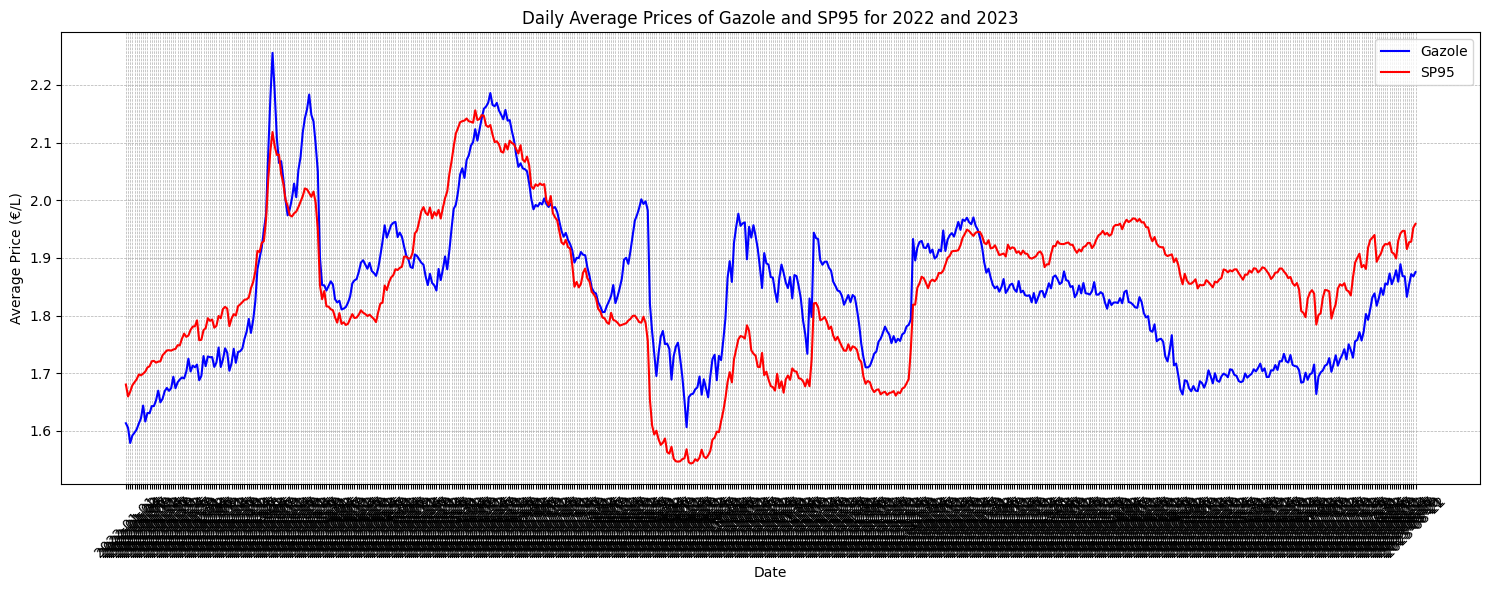

In [13]:
import os
import xml.etree.ElementTree as ET
import csv
import matplotlib.pyplot as plt

def extract_avg_prices(xml_file):
    gazole_prices = {}
    sp95_prices = {}

    for event, elem in ET.iterparse(xml_file, events=('end',)):
        if elem.tag == 'prix':
            fuel_type = elem.get('nom')
            maj_value = elem.get('maj')
            if maj_value:
                date = maj_value.split('T')[0]
                value = float(elem.get('valeur'))

                if fuel_type == "Gazole":
                    if date not in gazole_prices:
                        gazole_prices[date] = []
                    gazole_prices[date].append(value)

                elif fuel_type == "SP95":
                    if date not in sp95_prices:
                        sp95_prices[date] = []
                    sp95_prices[date].append(value)
            elem.clear()

    gazole_avg_prices = {date: sum(values) / len(values) for date, values in gazole_prices.items()}
    sp95_avg_prices = {date: sum(values) / len(values) for date, values in sp95_prices.items()}

    return gazole_avg_prices, sp95_avg_prices

# Folder containing the XML files
folder_path = "/content/datasets/french"  # Replace with the actual path

gazole_dataset = {}
sp95_dataset = {}

for xml_file in os.listdir(folder_path):
    if xml_file.endswith('.xml'):
        xml_path = os.path.join(folder_path, xml_file)
        gazole_avg, sp95_avg = extract_avg_prices(xml_path)

        gazole_dataset.update(gazole_avg)
        sp95_dataset.update(sp95_avg)

# Plotting the combined datasets
gazole_dates, gazole_avg = zip(*sorted(gazole_dataset.items()))
sp95_dates, sp95_avg = zip(*sorted(sp95_dataset.items()))

plt.figure(figsize=(15, 6))
plt.plot(gazole_dates, gazole_avg, label='Gazole', color='blue')
plt.plot(sp95_dates, sp95_avg, label='SP95', color='red')
plt.xlabel('Date')
plt.ylabel('Average Price (€/L)')
plt.title('Daily Average Prices of Gazole and SP95 for 2022 and 2023')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Writing the combined data to a CSV file
output_path = "combined_average_fuel_prices.csv"
with open(output_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Date', 'Gazole Average Price (€/L)', 'SP95 Average Price (€/L)'])
    for date in sorted(gazole_dataset.keys()):
        csvwriter.writerow([date, gazole_dataset.get(date, None), sp95_dataset.get(date, None)])
